<a href="https://colab.research.google.com/github/choiy5/AI-in-Physics-tutorial-STEM/blob/main/Final_AI_in_Physics_ML_STEM_Defect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI in Physics Hands-on Tutorial: Identifying point defects in STEM images of MoS2**

이번 세션에서는 딥러닝을 이용한 이미지 분석을 물리학, 그 중에서 고체 물리에서 어떻게 사용할 수 있는지 보겠습니다. 구체적으로, MoS2를 찍은 STEM 이미지에서 defect들을 찾아내는 딥러닝 모델을 만들고 학습시킨 후, 평가해보도록 하겠습니다.


---


**딥러닝에서 데이터 셋 (이미지 셋)의 역할**:

이미지 셋은 원리 설명이 없는 기출문제집이라고 볼 수 있는데, 모델은 이 기출문제집의 문제들을 풀고 답을 맞추면서 문제들이 테스트하고자 하는 개념을 배우게 됩니다.
(이미지=문제=Q.다음 이미지에서 defect들의 위치는?)
이 개념을 모델에게 잘 학습시켜서, 한번도 풀지 않은 새로운 문제들도 잘 맞출 수 있게 하는 것이 딥러닝을 접목한 이미지 분석의 목표입니다.



---


**STEM 이미지 딥러닝에서의 특이점**:

모델이 모든 종류의 defect에 대해서 한꺼번에 학습시키는 것보다, 각각의 defect 종류 찾는 것을 따로 학습을 하는게 더 효율적이라고 보고되고 있습니다. 문제집 비유에서는 문제 하나 당 한 개의 개념만 테스트하도록 문제를 만들어야 하기 때문에, 학습할 개념이 A, B 2가지면 A를 테스트하는 문제들로만 이루어진 문제집, B를 테스트하는 문제들만 있는 문제집, 총 2개의 문제집이 필요합니다.

우리가 테스트할 MoS2는 single-sulfur vacancy (1vac), double-sulfur vacancy (2vac) 2종류의 defect이 있기 때문에, 1vac용과 2vac용 이미지 세트 2개가 있습니다.

# **0. 환경 설정 하기**

먼저, 구글 드라이브를 코랩에 마운트합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


파이썬, 텐서플로우, 케라스 등 대부분 필요한 것들은 코랩에 이미 설치가 되어 있지만, 간혹 가다 필요하지만 없는 것은 !pip install을 이용해서 설치할 수 있습니다.

코랩어 설치되어 있지 않은 picke5 모듈(피클되어 있는 학습 데이터를 가지고 오고 원래 형태로 변환하기 위해) 과 tifffile 라이브러리(학습 및 테스트 tiff 이미지들을 사용하기 위해)를 설치합니다.

In [ ]:
# To load & unpickle the train & test files, which are provided in stem_tutorial as pickle files
!pip3 install pickle5

# Used to read in and visualize tiff images
!pip3 install tifffile

다음과 같이 필요한 케라스 모듈, 파이썬 라이브러리 및 마운트 한 구글드라이브의 stem_tutorial 안 파이썬 스크립트를 불러오겠습니다.


In [ ]:
# Keras with Tensorflow backend
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model

# Import necessary python libraries
# os: Module to interact with the operating system.
# Will need to call in train files from Google drive.
import os

# pickle5: to unpickle the train files in the form of pickle files
import pickle5 as pickle

# matplotlib.pyplot: Useful for plotting & visualizing data
import matplotlib.pyplot as plt

# NumPy: Numerial Python. 파이썬의 고성능 과학 계산용 패키지.
# Matrix, vector 같은 array 연산을 빠르고 효율적으로 함.
# 딥러닝 모델은 이미지들을 numpy array로 변환한 포맷으로 학습.
import numpy as np

# 구글 드라이브 안 파이썬 스크립트에서 정의된 함수들 불러 오기
import sys
sys.path.insert(0, '/content/gdrive/MyDrive/stem_tutorial/')
from evaluate_script import *

# **1. 학습 데이터 불러오기**

학습 데이터를 불러오기 위한 여러 가지 함수들을 정의하겠습니다. 자주 하게 되는 작업 (예: 특정 형태의 파일을 구글 드라이브에서 불러들이기, numpy 형태의 이미지를 시각화 등)을 함수로 정의해 놓으면, 그 작업을 할 때마다 유용하게 사용할 수 있습니다.

In [ ]:
def load_data(file_name):
  '''
  Loads a pickle file
  '''
  with open(file_name, 'rb') as f:
    return pickle.load(f)

In [ ]:
def visualize_data(image, label, index):
  '''
  Prints out a random image & label from the .p file
  '''
  plt.subplot(121), plt.imshow(image[index]), plt.title("Image")
  plt.xticks([]), plt.yticks([])
  plt.subplot(122), plt.imshow(label[index][:,:,1]), plt.title("Label")
  plt.xticks([]), plt.yticks([])
  plt.show()

In [ ]:
def open_file(data_dir):
  '''
  Loads and unpickles the train & test files and returns numpy arrays
  '''
  target_data = load_data(data_dir)

  print("Finished unpickling file.")
  image = np.asarray([target_data[i][0] for i in range(len(target_data))], dtype=np.float32)
  label = np.asarray([target_data[i][1] for i in range(len(target_data))], dtype=np.float32)
  print("Finished saving unpickled data into image & label np arrays")
  return image, label

이제 학습에 사용할 이미지 셋들을 가지고 오겠습니다. 학습 데이터는 /stem_tutorial/train_data안에 있는데, 세부 분류는 아래와 같습니다.

1. train_1vac: Single S-vacancy 찾는 학습을 위한 데이터 셋
  *   train_1vac.p (train set=학습을 위한 기출문제)
  *   val_1vac.p (validation set=학습 도중 잘 학습하고 있나 체크하기 위한 대단원 평가 문제)
2. train_2vac: Double S-vacancy 찾는 학습을 위한 데이터 셋
  *   train_2vac.p 
  *   val_2vac.p

하나의 train.p 파일 안에는 128 x 128 [px] 사이즈 이미지-라벨 pair들이 6888장 있고, val.p 파일 안에는 379장의 이미지-라벨 pair이 있습니다.

먼저, 가지고 올 파일들의 경로 설정을 해 줍니다.

In [ ]:
# Get the train and test files for single sulfur vacancy (SV1)

# (*) Set it as either "1vac" or "2vac"
vac_type = "2vac"

# Set the path to the files
data_dir = '/content/gdrive/MyDrive/stem_tutorial/train_data/train_' + vac_type

# train_f = data_dir + "train.p"
train_f = os.path.join(data_dir, "train_" + vac_type + ".p")
# test_f = data_dir + "test.p"
test_f = os.path.join(data_dir, "val_" + vac_type + ".p")

# Alternative: use a generator
# https://www.machinecurve.com/index.php/2020/11/03/how-to-evaluate-a-keras-model-with-model-evaluate/

그 후 open_file()을 이용해 학습 데이터를 로드해줍니다. (시간이 좀 걸립니다.)

In [ ]:
(train_image, train_label) = open_file(train_f)
(val_image, val_label) = open_file(test_f)

Finished unpickling file.
Finished saving unpickled data into image & label np arrays
Finished unpickling file.
Finished saving unpickled data into image & label np arrays


train.p의 이미지-라벨 pair는 0부터 (이미지 사이즈-1) 까지 indexing 되어서 들어 있기 때문에, 인덱스 n=0-6887 사이의 정수로 설정해서 해당 이미지와 라벨을 시각할 수 있습니다.

(마찬가지로, val.p 파일 안 이미지-라벨 pair은 n=0-378까지 인덱싱 되어 있습니다.)

100th image in train set


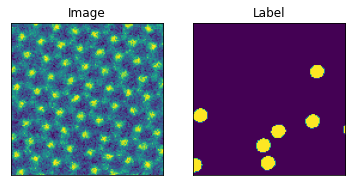

90th image in test set


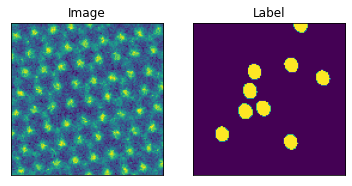

In [ ]:
n = 100
print(str(n) + "th image in train set")
visualize_data(train_image, train_label, n)

m = 90
print(str(m) + "th image in test set")
visualize_data(val_image, val_label, m)

왼쪽이 학습에 사용할 이미지이고, 오른쪽이 defect들의 위치를 표시한 라벨 이미지입니다.



# **2. 모델 정의**

아래의 model_fcn() 함수를 이용해서 사용할 모델을 정의해보도록 하겠습니다.

들어가는 변수의 종류는 5가지입니다.

(1) input_img: 이미지의 모양. Input(shape=(width, height, depth))의 형태를 가집니다. 이미지는 넓이, 높이 외에도 색을 가진 경우 두께라는 세번째 변수가 있는데, RGB 이미지의 경우에는 depth=3, 우리가 사용하는 흑백 이미지의 경우에는 depth=1입니다.

(2) kernel: 이미지에서 중요한 feature들을 추출할 때 사용하는 윈도우 사이즈. 

(3) N: (이미지가 정사각형이라는 가정하에) 이미지 변의 길이.

(4) nb_classes: 모델이 학습하는 feature의 가지수. 현재 학습은 single sulfur vacancy인지 아닌지에 대한 것이기 때문에 2로 설정합니다.


In [ ]:
'''
Inputs:
(1) input_img = shape of the input image (assume square image)
(2) kernel = the filter size to extract the important features in input_img
(3) N = image size
(4) k_fac = common factor to multiply # of channels in each layer
(5) nb_classes: # of classes for the model to distinguish. This value is always 2 (defect vs. non-defect)
'''
def model_fcn(input_img, N, kernel, n_filters=4, nb_classes=2):

  # Convolution
  x = Conv2D(2*n_filters, kernel, activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2,2), padding = 'same')(x)
  x = Conv2D(4*n_filters, kernel, activation='relu', padding='same')(x)
  x = MaxPooling2D((2,2), padding='same')(x)
  x = Conv2D(8*n_filters, kernel, activation='relu', padding='same')(x)
  x = MaxPooling2D((2,2), padding='same')(x)
  
  # Deconvolution
  x = Conv2D(8*n_filters, kernel, activation='relu', padding='same')(x)
  x = UpSampling2D((2,2))(x)
  x = Conv2D(4*n_filters, kernel, activation='relu', padding='same')(x)
  x = UpSampling2D((2,2))(x)
  x = Conv2D(2*n_filters, kernel, activation='relu', padding='same')(x)
  x = UpSampling2D((2,2))(x)
  
  # Final 
  x = Conv2D(nb_classes, kernel, activation='linear', padding='same')(x)
  # 1x1 convolution layer to do the classification task (defect or atom).
  # Note: There is no dense layer, hence "fully-convolutional" neural network
  x = Conv2D(nb_classes, (1,1), activation='linear', padding='same')(x)
  x = Reshape((N, N, nb_classes))(x)
  output = Activation('softmax')(x)

  return Model(input_img, output)

우선, 사용할 이미지 사이즈, 커널 사이즈, 그리고 각 레이어마다의 필터 개수에 곱해지는 common factor을 정하겠습니다.

In [ ]:
# Image dimension (assume square image)
N=128

# Kernel size
kernel = (7,7)

# Common factor to multiply number of filters in each layer
n_filters=4

# Shape of the image
input_image = Input(shape=(N,N,1))

위에서 정의한 함수 model_fcn()을 이용해서 모델을 만들겠습니다.

In [ ]:
# Create an instance of the model

model = model_fcn(input_image, N, kernel, n_filters)

이제 compile()을 이용해서 모델을 기계가 이해할 수 있도록 컴파일 합니다. 설정해야 할 몇 가지 변수는 아래와 같습니다.

(1) optimizer: 학습 속도 조절하는 수리 계획.
(https://gomguard.tistory.com/187)

(2) loss: 모델의 예측과 실제 답 사이의 오차를 수치화하는 손실 함수.

(3) metrics: 학습 시 중점적으로 모니터링할 지표. 대표적인 예로 accuracy가 있습니다.

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Metrics 종류에 대해:**


*   Accuracy
*   Recall
*   Precision
*   F1_score




In [ ]:
from keras import backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from tensorflow.keras.callbacks import Callback

class Metrics(Callback):
    def __init__(self, validation):   
        super(Metrics, self).__init__()
        self.validation = validation    
            
        print('validation shape', len(self.validation[0]))
        
    def on_train_begin(self, logs={}):        
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
     
    def on_epoch_end(self, epoch, logs={}):
        val_targ = self.validation[1]   
        val_predict = (np.asarray(self.model.predict(self.validation[0]))).round()        
    
        val_f1 = f1_score(val_targ, val_predict)
        val_recall = recall_score(val_targ, val_predict)         
        val_precision = precision_score(val_targ, val_predict)
        
        self.val_f1s.append(round(val_f1, 6))
        self.val_recalls.append(round(val_recall, 6))
        self.val_precisions.append(round(val_precision, 6))
 
        print(f' — val_f1: {val_f1} — val_precision: {val_precision}, — val_recall: {val_recall}')

[Metrics(validation=(x_val, y_val))], 

In [ ]:
# Compiles the model using an optimizer, a loss function, and metrics to monitor
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

만든 model에 model.summary()를 이용해서 모델의 구조를 출력해서 볼 수 있습니다. 또는 plot_model()을 이용하면 모델의 구조를 시각화해서 볼 수 있습니다.

In [ ]:
# Provides a structure of the model
model.summary()

# Visualizes the structure of the model
plot_model(model, to_file='model.png')

*Optional: You can try using a different model, either by modifying the model_fcn() method, or by importing a pre-trained model from keras. To use models from keras, refer to the examples below.

In [ ]:
'''
Imports ResNet50 from Keras
'''
from keras.applications.resnet50 import ResNet50
# load model
model_res = ResNet50()
# summarize the model
model_res.summary()
plot_model(model_res, to_file='modelres.png')


'''
Imports VGG16 from Keras
'''
from keras.applications.vgg16 import VGG16

# load model and specify a new input shape for images and avg pooling output
new_input = Input(shape=(640, 480, 3))
vmodel = VGG16(include_top=False, input_tensor=new_input, pooling='avg')
vmodel.summary()
plot_model(vmodel, to_file='VGG16_model.png')

# **3. 모델 학습**

이제 fit() 메소드를 사용해서 학습을 위한 이미지와와 라벨 이미지들을 정의된 FCN 모델에 주입하고 학습을 진행합니다.

fit()에 들어가는 변수는 아래와 같습니다.

(1) **train_image**: 위에서 불러들인 학습용 이미지 (기출문제)

(2) **train_label**: 위에서 불러들인 학습용 이미지에 대한 vacancy 위치를 표시한 라벨 (기출문제 답)

(3) **batch_size**: 몇 개의 문제를 풀고 답을 맞출지를 의미. 즉, batch_size 개수의 이미지에 대해 모델이 vacancy들의 위치를 예측하고, 한꺼번에 라벨 이미지들과 비교해서 답을 맞춥니다. 그렇게 답을 맞추고 네트워크의 가중치를 갱신합니다.

(4) **epochs**: 주어진 학습용 이미지 세트 (기출문제집)를 몇 번 반복학습 하는지를 의미. epoch이 1이면 문제집을 한번만 푸는 것이고, 10이면 10번 반복해서 풉니다. 같은 문제를 반복해서 풀어도 학습이 일어나지만, 너무 많이 풀면 문제를 통한 진정한 학습보다는 자칫 문제집 문제와 답을 외우게 되는 것처럼, epoch이 크면 클수록 overfitting의 위험도 늘어납니다.

(5) **validation data**: 모델이 학습하는 도중에 얼마나 잘 배우고 있는지 평가하기 위한 이미지셋 (기출 문제집 단원마다 있는 대단원 평가파트). 위에서 불러들인 (val_image, val_label)을 넣습니다.

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

model.fit(train_image, train_label, batch_size=32, epochs=2, validation_data=(val_image, val_label, callbacks=model_checkpoint_callback, verbose=1)

In [ ]:
# Trains the model with the train & validation data provided above
model.fit(train_image, train_label, batch_size=32, epochs=10, validation_data=(val_image, val_label), verbose=1)

Epoch 1/10
216/216 [==============================] - 616s 3s/step - loss: 0.1936 - accuracy: 0.9578 - val_loss: 0.0649 - val_accuracy: 0.9760
Epoch 2/10
216/216 [==============================] - 623s 3s/step - loss: 0.0747 - accuracy: 0.9722 - val_loss: 0.0396 - val_accuracy: 0.9848
Epoch 3/10
216/216 [==============================] - 617s 3s/step - loss: 0.0485 - accuracy: 0.9821 - val_loss: 0.0335 - val_accuracy: 0.9872
Epoch 4/10
216/216 [==============================] - 616s 3s/step - loss: 0.0394 - accuracy: 0.9854 - val_loss: 0.0301 - val_accuracy: 0.9882
Epoch 5/10
216/216 [==============================] - 615s 3s/step - loss: 0.0340 - accuracy: 0.9873 - val_loss: 0.0275 - val_accuracy: 0.9897
Epoch 6/10
216/216 [==============================] - 620s 3s/step - loss: 0.0305 - accuracy: 0.9885 - val_loss: 0.0231 - val_accuracy: 0.9910
Epoch 7/10
216/216 [==============================] - 628s 3s/step - loss: 0.0273 - accuracy: 0.9897 - val_loss: 0.0296 - val_accuracy: 0.9890

학습을 완료한 모델을 save()를 이용해 저장하겠습니다.

save()에 들어가는 변수는 하나입니다.

* name = 'some_name' (some_name을 원하는 이름으로 바꾸기)

save(name)을 이용하면, name에 해당하는 이름의 폴더가 생성이 되고, 그 안에 assets라는 폴더가 또 생성이 된 것을 볼 수가 있는데, 이 안에 학습한 모델을 재구성할 수 있는 모든 정보가 들어가 있습니다.

In [ ]:
# Saves the trained model.
# model.save('sv1_model') will create a folder called sv1_model and save the model inside
name = 'sv1_model'
model.save(name)

NameError: ignored

# **4. 학습한 모델 평가**

이제 저장한 모델을 하나씩 불러들여서 테스트 이미지에 대해서 얼마나 vacancy를 잘 찾아내고 구분하는지 평가하겠습니다.

먼저 주어진 테스트 이미지 폴더 안에서 시뮬레이션 이미지 한 장을 불러오겠습니다.

In [ ]:
"""
Methods used to evaluate the model:
Read in the input & label images and print them out as predictions.
"""

def display(a, b, title1 = "Test Image", title2 = "Test Label"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

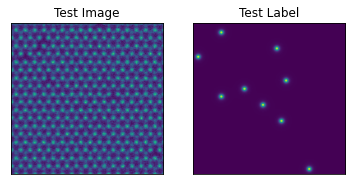

In [ ]:
# Directory where the test image is saved
test_image_dir='/content/gdrive/MyDrive/stem_tutorial/test_images/simulated_image'
# Get the test image from the specified directory
test_image = os.path.join(test_image_dir, "input.tif")
# Get the test label from the specified directory
test_label = os.path.join(test_image_dir, "label_1vac.tif")

# Visualize the test image using matplotlib's imread function
display(test_img, test_lab)

이제 저장한 모델 하나를 load_model()을 이용해서 불러들이겠습니다.

In [ ]:
loaded_model = load_model('sv1_model')

ValueError: ignored

아래 evaluate() 함수는 불러들인 테스트 이미지와 그 라벨에 대해서 모델이 예측하는 답안을 함께 이미지로 출력해서 보여줍니다.

In [ ]:
def evaluate_custom(model, test_image, test_label, avg=True):

  input_img = process_image(test_image, standardize=True)
  (size_x, size_y) = input_img.shape
  avg = True
  l_shape = (256, 256)
  stride = (32, 32)

  (lx, ly) = l_shape
  (sx, sy) = stride if stride != None else (get_s(size_x, lx), get_s(size_y, ly))
  print("strides: ({}, {})".format(sx, sy))

  input_cuts = cut_data(input_img, lx, ly, (sx, sy))
  input_cuts = np.reshape(input_cuts, [-1, lx, ly, 1])
  num_cuts = len(input_cuts)

  print("predicting data")
  predictions = np.array([get_avg_pred(model,cut) for cut in input_cuts] if avg else predict(model,input_cuts))
  predictions = np.reshape(np.array(predictions), [num_cuts, lx, ly, -1])

  print("stitching data")
  a = stitch(size_x, size_y, sx, sy, predictions)
  a = np.argmax(a, axis=2)

  plt.subplot(131), plt.imshow(test_img), plt.title("Image")
  plt.xticks([]), plt.yticks([])
  plt.subplot(132), plt.imshow(a), plt.title("Model Prediction")
  plt.xticks([]), plt.yticks([])
  plt.subplot(133), plt.imshow(test_lab), plt.title("Label")
  plt.xticks([]), plt.yticks([])
  plt.show()


evaluate()을 이용해 불러들인 모델에게 테스트 이미지를 주고, 모델의 답안과 실제 답을 이미지로 출력해서 비교해 보겠습니다.

In [ ]:
evaluate_custom(model, test_image, test_label)